# The Monte-Carlo process
## Goal of this code

This code is made for generating thousands of synthetic time series based on Image Quilting. It is largely inspired by J. Hoffimann's work that you can find [here](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2019JF005245).

As explained in the paper, the two stochastic parameters that rule the Poisson law (lambda) and the transition probabilities matrix (sigma) of the experiment are unknown. To find them, we use a Monte-Carlo method to generate a lot of time series with random values of lambda and sigma to then compare them with the original time serie. We do the comparison in the next notebook.

## How this code works ?

These are the steps of the program :
1. We create a pool of centroids : we generate a lot of pictures (like 100) of the centroids using Image Quilting (with the parameters that we found earlier).
2. We found the good range of sigma with visual inspection of the transition probabilities matrix. The good range of lambda depends on the frequency we want for the transition of modes : 1/lambda is the average time spent in one mode so we can adjust the range knowing this.
3. For each value of sigma and lambda, we create the list of modes generated by the Markov chain. Basically, this is just a list that tells in which mode the system is at every index. For example, the list could be : [1,1,1,1,5,5,3,3,3,3,3] which tells us that the system stays first 4 iterations in mode 1, then 2 in mode 5 and finally 5 in mode 3. Here, lambda is usefull to generate the time the system spends in one mode, based on the Poisson law. And when this time is over, the system changes of mode with the matrix of probabilities of transition using a simple Markov chain.
4. Once we have the list of modes for the generated time serie, we pick a random picture within the pool of the right centroid for every index. This method is much faster than just generating pictures with Image Quilting for all the time series and it does not affect the generated time serie.
5. We save all the images in a folder and we do the steps 3 and 4 `numTimeSeries` times with differents values of lambda and sigma.

## The parameters

### For the pool of centroids
- `folderCentroids` is the path of the folder where you saved the pictures that represent each mode of your experiment.
- `folderGeneratedCentroids` is the path of the folder where the pool of centroids will be saved. It will be filled with `numCentroids` folders of `stepmaxCentroids` pictures that look like each centroid.
- `stepmaxCentroids` is the number of pictures you want to generate for each centroid.
- `blur`, `overlap` and `tilesize` are the parameters of the IQ that we found in the previous notebook. `blur` must be an odd unsigned int, `overlap` is a couple of values between 0 and 1 and `tilesize` is a couple of unsigned int representing the dimension of the tile in pixels. 

### For the visual inspection of the matrix of probabilities
- `D` and `pi` are the distance matrix and the pi distribution that were computed before. We should load them by putting the path where they are saved
- `sigma` is the dispersion parameter that we want to move to see the evolution of `P` which is the probability matrix.

### For the generation of synthetic time series
- `folderCentroids` is the path of the folder where you saved the pictures that represent each mode of your experiment.
- `parent_folder` is the path of the folder where you want to save your generated pictures. It will be filled with `numTimeSeries` folders that each contains `stepmax` pictures.
- `folderExp` is the path of the folder where the pictures of the experiment are saved.
- `numTimeSeries` is the number of time series of `stepmax` pictures you want to generate. `stepmax` is by default the same amount of pictures that are in `folderExp`. For a good Mont-Carlo process, `numTimeSeries` should climb up to thousands.
- `lambda` and `sigma` are the stochastic parameters that we move in this Monte-Carlo process. The minimum and maximum values of the uniform law should be chosen by instinct, testing and visual inspection.

## The functions

All the functions used in the notebook are in the `functionsGeneration.py` file. here is a small description of each one of them :

- `pngToGslib` converts every image into a gslib file. This type of file is used in the image quilting package from J. Hoffimann in Julia. The gslib format is well used in geostatistics to convert a 3D map into a 2D projection. Because we use only 2D images, the gslib conversion is very simple.
- `imageQuilting` generates one picture based on a training image. It is just the main code of Hoffimann in Julia that is imported in Python.
- `transition_probabilities` calculates the matrix of probabilities of transition between modes by using the method explained in Appendix A of the paper.
- `markov_chain` creates the list of modes as explained in the introduction. The system starts in a mode chosen with the pi distribution, then the programm generates a time in which the system stays in the same mode. It repeats the mode for the good number of iterations. Then, the system changes of mode using the matrix of probabilities. Finally, the code repeats this process until the list is full.

# Importing the librairies

In [4]:
# Librairies
from os.path import join
import numpy as np
import random
from sklearn.preprocessing import normalize
from PIL import Image
import os
from scipy.optimize import minimize
import cv2
import imageio
import time
from juliacall import Main as jl
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import shutil

import functionsGeneration as f

# The pool of centroids

Here, we generate a consequent amount of pictures for each centroid using the Image Quilting parameters that we found before. This way, we will have a "pool" of centroids in which we will pick random pictures to create synthetic time series. 

We just have to enter the right folders and the number of generated images we want for each centroid and the program runs automatically.

Be careful : just as before, if an error of type "JuliaError: AssertionError: image not available" occurs, you should go into the `GeoStatsImages` package in the `.julia` folder and open the `GeoStatsImages.jl` as an administrator. Then, you must modify the datadir to be exactly the same from `folderCentroids`. Save the file, restart the kernel of the notebook and run the code again.

In [2]:
# Folder where the centroids are saved
folderCentroids = 'C:/Users/EPFL-LHE/Documents/Arthur/Centroids/FINALCentroids'
# Folder where the generated images will be saved
folderGeneratedCentroids = 'C:/Users/EPFL-LHE/Documents/Arthur/GeneratedCentroids'

# Choose the number of generated centroids
stepmaxCentroids = 100

# Parameters of the Image Quilting (Put the good ones)
blur = 3
overlap = (0.54, 0.54)
tilesize = (23, 15)

# Create the folder to store the generated images if it is not created yet
os.makedirs(folderGeneratedCentroids, exist_ok=True)

# Start the stopwatch
start_time0 = time.time()

# Get the number of centroids 
allFiles = os.listdir(folderCentroids)
centroid_files = [file for file in allFiles if file.endswith(".png")]
numCentroids = len(centroid_files)

# Get the size of the centroids
centroidName = join(folderCentroids, centroid_files[0])
centroid1 = cv2.imread(centroidName)
l = centroid1.shape[0]
c = centroid1.shape[1]
TIsize = [l, c]   

# Create the .gslib file for each centroid in the folder
for i in range(numCentroids):
    nom_centroid = join(folderCentroids, centroid_files[i])
    # Create the .gslib file
    f.pngToGslib(nom_centroid)

# Generate stepmaxCentroids pictures for every centroids
for c in range(numCentroids):
    # Create a new folder for each centroid
    suffix = f'Centroid{c:02d}'
    newFolder = join(folderGeneratedCentroids, suffix)
    os.makedirs(newFolder, exist_ok=True)
    
    for k in range(stepmaxCentroids):
        # Get the name of the centroid for the .gslib file
        TIname = os.path.splitext(os.path.basename(centroid_files[c]))[0]
        # Generate a synthetic picture based on the mode list and on the chosen parameters
        simulated_picture = f.imageQuilting(TIname, TIsize, blur, overlap, tilesize)
        # Convert it to regular format
        simulated_picture = (simulated_picture * 255).astype(np.uint8)
        # Check if working
        print(f"The picture n°{k+1} of the centroid n°{c} is generated")
        # Write the image in the folder
        image_path = os.path.join(newFolder, f'image_{k:03d}')
        imageio.imwrite(image_path + '.png', simulated_picture)

# Computing the general duration of the code
end_time0 = time.time()
duration0 = end_time0 - start_time0
duration0 = duration0/60
print(f"The whole code took {duration0} minutes to run.")

The picture n°1 of the centroid n°0 is generated
The picture n°2 of the centroid n°0 is generated
The picture n°3 of the centroid n°0 is generated
The picture n°4 of the centroid n°0 is generated
The picture n°5 of the centroid n°0 is generated
The picture n°6 of the centroid n°0 is generated
The picture n°7 of the centroid n°0 is generated
The picture n°8 of the centroid n°0 is generated
The picture n°9 of the centroid n°0 is generated
The picture n°10 of the centroid n°0 is generated
The picture n°11 of the centroid n°0 is generated
The picture n°12 of the centroid n°0 is generated
The picture n°13 of the centroid n°0 is generated
The picture n°14 of the centroid n°0 is generated
The picture n°15 of the centroid n°0 is generated
The picture n°16 of the centroid n°0 is generated
The picture n°17 of the centroid n°0 is generated
The picture n°18 of the centroid n°0 is generated
The picture n°19 of the centroid n°0 is generated
The picture n°20 of the centroid n°0 is generated
The pictu

# The generation of synthetic time series

## Finding the good range of sigma

Before generating a lot a synthetic time series, we must think a little about the bounds of the uniform law that sigma is parametized with. 

A good way of estimating a range for sigma is to plot the transition probabilities matrix with different values of sigma. If sigma is too small, the matrix will only have ones on the diagonal because the system can not go from one mode to another. The system is too restrictive. If sigma is too big, the matrix will be uniform as all the modes can be accessible no matter their dissimilarity. We are then too dispersed.

We should choose a range of sigma that captures the whole evolution of the matrix, form diagonal to uniform.

It is relevant to point out that the probability matrix depends on the distance matrix : if this matrix have high values, the probabilities will be affected which will change the right range of sigma.

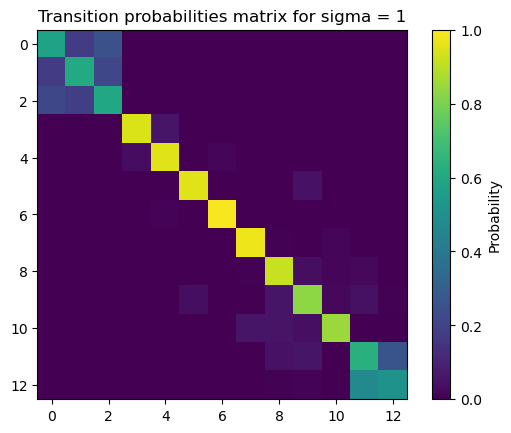

In [25]:
## Load the distance matrix and the pi distribution
D = np.load('C:/Users/EPFL-LHE/Documents/Arthur/NPYFiles/FINALDistanceMatrix/UMAPdistance.npy')
pi = np.load('C:/Users/EPFL-LHE/Documents/Arthur/NPYFiles/FINALDistanceMatrix/pi.npy')

# Choose a sigma
sigma = 1

# Compute the matrix of probabilities of transition
P = f.transition_probabilities(D, sigma, pi)

# Plot the matrix
plt.imshow(P, vmin=0, vmax=1)
plt.title(f'Transition probabilities matrix for sigma = {sigma}')
plt.colorbar(format='%.1f', label='Probability')
plt.show()

## Generating the time series

Here we generate a high number of synthetic time series with different values of sigma and lambda that follow uniform laws. This process is quite fast thanks to the pool of centroids, make just sure that you have enough storage on your computer if you generate a very high number of time series.

In [21]:
# Folder where the centroids are saved
folderCentroids = 'C:/Users/EPFL-LHE/Documents/Arthur/GeneratedCentroids'
allFoldersCentroids = os.listdir(folderCentroids)

# Folder where the generated images will be saved
parent_folder = 'C:/Users/EPFL-LHE/Documents/Arthur/GeneratedTimeSeries'

# Folder of the experimental time serie
folderExp = 'C:/Users/EPFL-LHE/Documents/Arthur/Experiment-Hoffiman-BW/BW-oneDay'

# Put the number of time series you want
numTimeSeries = 10000 

# Bounds of the stochastic parameters => put the values you want based on instinct an visual inspection
lambda_min = 0.001
lambda_max = 0.5
sigma_min = 0.1
sigma_max = 15

# Get the number of experimental pictures
allFiles = os.listdir(folderExp)
files = [file for file in allFiles]
stepmax = len(files)

# MonteCarlo process
start_time = time.time()
for k in range(numTimeSeries):
    # Stochastic parameters 
    lambdaa = random.uniform(lambda_min, lambda_max)
    sigma = random.uniform(sigma_min, sigma_max)

    # Print a message for the value of the stochastic parameters
    print(f"Serie n°{k+1}: sigma = {sigma:.2f} and lambda = {lambdaa:.2f}")
    
    # Compute the transition probability matrix for those values of lambda and sigma
    P = f.transition_probabilities(D, sigma, pi)
    
    # Get the list of modes for this time serie
    mode_list = f.markov_chain(P, stepmax, lambdaa, pi)
    mode_list = mode_list.astype(np.uint8)
    
    # Creates a new folder where the generated images will be saved
    new_folder_path = os.path.join(parent_folder, f'TimeSeries_{k:04d}(s={sigma:.2f},lbd={lambdaa:.3f})')
    os.makedirs(new_folder_path, exist_ok=True)
        
    # Generation of the pictures
    for i in range(stepmax):
        # Get the path of the centroid to copy
        fullFolderPath = os.path.join(folderCentroids, allFoldersCentroids[mode_list[i]])
        fullFolderPath = fullFolderPath.replace("\\", "/")
        allFiles = os.listdir(fullFolderPath)
        images = [file for file in allFiles]
        numFiles = len(images)
        
        # Take a random one among all of the generated pictures for one centroid
        random_number = random.randint(0, numFiles-1)
        image_name = join(fullFolderPath, images[random_number])
        imagePath = os.path.join(new_folder_path, f'image_{i:03d}.png')
        
        # Copy paste the image into the right folder
        shutil.copy(image_name, imagePath)
   
# Print the duration of the program
end_time = time.time()
duration = end_time - start_time
duration = duration/60
print(f"The {numTimeSeries} time series took {duration} minutes to run.")

Serie n°1: sigma = 10.43 and lambda = 0.29
Serie n°2: sigma = 5.94 and lambda = 0.31
Serie n°3: sigma = 2.77 and lambda = 0.28
Serie n°4: sigma = 2.42 and lambda = 0.26
Serie n°5: sigma = 1.95 and lambda = 0.47
Serie n°6: sigma = 14.15 and lambda = 0.27
Serie n°7: sigma = 8.78 and lambda = 0.39
Serie n°8: sigma = 10.51 and lambda = 0.34
Serie n°9: sigma = 10.49 and lambda = 0.37
Serie n°10: sigma = 7.11 and lambda = 0.22
Serie n°11: sigma = 7.78 and lambda = 0.05
Serie n°12: sigma = 12.49 and lambda = 0.11
Serie n°13: sigma = 11.11 and lambda = 0.31
Serie n°14: sigma = 7.69 and lambda = 0.33
Serie n°15: sigma = 11.96 and lambda = 0.18
Serie n°16: sigma = 13.72 and lambda = 0.06
Serie n°17: sigma = 11.49 and lambda = 0.16
Serie n°18: sigma = 5.63 and lambda = 0.09
Serie n°19: sigma = 10.29 and lambda = 0.21
Serie n°20: sigma = 14.04 and lambda = 0.15
Serie n°21: sigma = 12.09 and lambda = 0.18
Serie n°22: sigma = 11.75 and lambda = 0.39
Serie n°23: sigma = 7.30 and lambda = 0.38
Serie n

C:\Users\EPFL-LHE\mambaforge\envs\Arthur\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Serie n°168: sigma = 14.78 and lambda = 0.42
Serie n°169: sigma = 9.01 and lambda = 0.09
Serie n°170: sigma = 3.32 and lambda = 0.38
Serie n°171: sigma = 5.86 and lambda = 0.37
Serie n°172: sigma = 7.85 and lambda = 0.38
Serie n°173: sigma = 4.85 and lambda = 0.09
Serie n°174: sigma = 7.21 and lambda = 0.44
Serie n°175: sigma = 11.77 and lambda = 0.23
Serie n°176: sigma = 12.27 and lambda = 0.17
Serie n°177: sigma = 11.95 and lambda = 0.02
Serie n°178: sigma = 4.16 and lambda = 0.16
Serie n°179: sigma = 14.84 and lambda = 0.36
Serie n°180: sigma = 9.80 and lambda = 0.15
Serie n°181: sigma = 3.32 and lambda = 0.38
Serie n°182: sigma = 8.48 and lambda = 0.31
Serie n°183: sigma = 11.53 and lambda = 0.15
Serie n°184: sigma = 13.54 and lambda = 0.33
Serie n°185: sigma = 3.39 and lambda = 0.09
Serie n°186: sigma = 12.81 and lambda = 0.08
Serie n°187: sigma = 10.31 and lambda = 0.23
Serie n°188: sigma = 11.62 and lambda = 0.25
Serie n°189: sigma = 12.45 and lambda = 0.05
Serie n°190: sigma = 